In [2]:
import graphviz as gv #Graficos
import numpy as np
import heapq as hq
import pandas as pd #Leer CSV
import matplotlib.pyplot as plt # Gragicos final
import math as math #Operaciones matematicas
from timeit import timeit

def readAdjl(fn, haslabels=False, weighted=False, sep="|"):
  with open(fn) as f:
    labels = None
    if haslabels:
      labels = f.readline().strip().split()
    L = []
    for line in f:
      if weighted:
        L.append([tuple(map(int, p.split(sep))) for p in line.strip().split()])
        # line => "1|3 2|5 4|4" ==> [(1, 3), (2, 5), (4, 4)]
      else: 
        L.append(list(map(int, line.strip().split()))) # "1 3 5" => [1, 3, 5]
        # L.append([int(x) for x in line.strip().split()])
  return L, labels

def adjlShow(L, labels=None, directed=False, weighted=False, path=[],
             layout="sfdp"):
  g = gv.Digraph("G") if directed else gv.Graph("G")
  g.graph_attr["layout"] = layout
  g.edge_attr["color"] = "gray"
  g.node_attr["color"] = "orangered"
  g.node_attr["width"] = "0.1"
  g.node_attr["height"] = "0.1"
  g.node_attr["fontsize"] = "8"
  g.node_attr["fontcolor"] = "mediumslateblue"
  g.node_attr["fontname"] = "monospace"
  n = len(L)
  for u in range(n):
    g.node(str(u), labels[u] if labels else str(u))
  added = set()
  for v, u in enumerate(path):
    if u != None:
      g.edge(str(u), str(v), dir="forward", penwidth="2", color="orange")
      added.add(f"{u},{v}")
      added.add(f"{v},{u}")
  if weighted:
    for u in range(n):
      for v, w in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v), str(w))
        elif directed:
          g.edge(str(u), str(v), str(w))
  else:
    for u in range(n):
      for v in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v))
        elif directed:
          g.edge(str(u), str(v))
  return g

# Cosas Extras(pero necesarias)

In [5]:
def toPosition(x, y, n):
  return x + y*n;

def adjacents(x, y, n):
  dir = []
  coords = [[x, y-1],[x-1, y],[x+1, y],[x, y+1]]
  for c in coords:
    if c[0] != -1 and c[0] != n and c[1] != -1 and c[1] != n:
      dir.append(toPosition(c[0], c[1], n))
  return dir

In [6]:
# st = data almacenes, dp = data puntos de entrega
# n = tamaño de la matriz cuadrada
def get_ls(st, dp, n):
  ls = []
  locals = []
  for y in range(n): #Caso optimizado -> Y menor - al Y Mayor
    for x in range(n): 
      tp = 0      
      if [x,y] in st:
        tp = 1        
      if [x,y] in dp:
        tp = 2
      ls.append(adjacents(x, y, n))
      locals.append(tp)
  return ls, locals

In [7]:
def toListWithCosts(G):
  new_list = []
  for c in G:
    l = []
    for n in c:
      l.append((n,1))
    new_list.append(l)
  return new_list

In [8]:
almac = [[0,0],[2,1]]
pts_entreg = [[1,0],[0,2]]

ls,loc = get_ls(almac, pts_entreg, 3)

print(ls)
print(loc)

[[1, 3], [0, 2, 4], [1, 5], [0, 4, 6], [1, 3, 5, 7], [2, 4, 8], [3, 7], [4, 6, 8], [5, 7]]
[1, 2, 0, 0, 0, 1, 2, 0, 0]


Estas funciones sirven para dos cosas. La primera es para ver los vertices adyacentes de un mismo vertice. Y la segunda cosa que revela la funcion es saber que tipo de local es ese vertice. 0 es que es un vertice vacio, 1 que es un almacen y 2 que es un punto de entrega.

Esto va servir para modificar el algortimo de Dijkstra y que recorra solo hacia los puntos que nosotros queramos.

# Algoritmo Dijkstra

Analisaremos el algoritmo Dijkstra, tambien llamado "Algoritmo de caminos minimos" y veremos su efectividad que tendria en la aplicación del grafo final.

El Algoritmo de Dijkstra tiene una notación O(V^2) por lo que me da a entender que mientras vertices tenga el grafo más sera su notación. Y que el tiempo de ejecución sera más grande mientras más grande sea el grafo.

Vertices: 1000000. Notación Algoritmo Dijkstra: O(1000000^2). Y tenemos que tener en cuenta que se repetira 60 veces, 1 por cada almacen que hay. Todo esto hace que este algoritmo no sea una solución tan óptima.

Este algortimo por la notación que posee no es la ideal para trabajar con grafos grandes. Existen mejores opciones como el algoritmo Kruskal, Bellman-Ford o Floyd Warshall. Pero eso no significa que el algortimo sea inutil, se le pueden hacer algunas modificaciones para que sea más efectivo

In [11]:
def dijkstraB(G, s):
  n = len(G)          
  visited = [False]*n 
  path = [None]*n     
  cost = [math.inf]*n 
  cost[s] = 0         
  queue = [(0, s)]    
  while queue:
    g_u, u = hq.heappop(queue) 
    if not visited[u]:
      visited[u] = True 
      for v, w in G[u]:
        f = g_u + w 
        if f < cost[v]:
          cost[v] = f 
          path[v] = u 
          hq.heappush(queue, (f, v)) 

  return path, cost

# Algoritmo Dijkstra Mejorado

Para que el Algoritmo de Dijkstra pueda cumplir todas las condiciones que nosotros como equipo necesitamos, se tuvo que hacer algunas modificaciones.

Las modificaciones que se realizaron al algortimo para que cumpla con los requisitos que nosotros necesitamos fue el de agregar una parte extra de codigo, este codigo basicamente es un filtro y solo deja que algoritmo encuentre el camino menos pesado solo a ciertos puntos y no todos los puntos del grafo.

Esta modificacion va ayudar mucho a reducir el tiempo de compilación ya que lo que hace el Algoritmo de Dijkstra es encontrar el camino menos pesado a cada nodo del grafo, esto significa que mientras más grande el grafo más se va a demorar en sacar una respuesta. Con nuestra respuesta el tiempo va a ser menor porque no le pediremos que encuentre el camino a todos los nodos sino solo a los que nostros queramos.

In [12]:
def dijkstra(G, L, s):
  n = len(G)          
  visited = [False]*n 
  path = [None]*n     
  cost = [math.inf]*n 
  cost[s] = 0         
  queue = [(0, s)]    
  while queue:
    g_u, u = hq.heappop(queue) 
    if not visited[u]:
      visited[u] = True 
      for v, w in G[u]:
        f = g_u + w 
        if f < cost[v]:
          cost[v] = f  
          path[v] = u 
          hq.heappush(queue, (f, v)) 

  min_path = [None]*n
  for i, v in enumerate(L):
      if v == 2:
        min_path[i] = path[i] 
        m = path[i] 
        while m != s:          
          min_path[m] = path[m] 
          m = path[m] 

  return min_path, cost

# Funcionamiento Algoritmo Mejorado

In [ ]:
almac = [[0,0],[2,1]]
pts_entreg = [[1,0],[0,2]]

ls, loc = get_ls(almac, pts_entreg, 3)
G = toListWithCosts(ls)
G, loc

[None, 2, 5, 4, 5, None, 3, None, None]
[3, 2, 1, 2, 1, 0, 3, 2, 1]


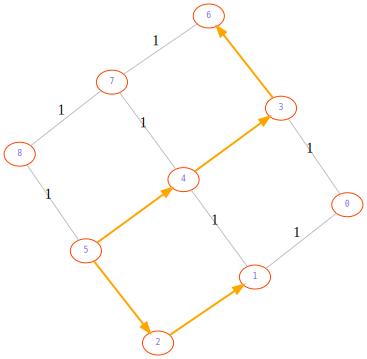

In [16]:
path, cost = dijkstra(G, loc, 5)
print(path)
print(cost)
# path = [None, 0, None, 0, None, None, 3, None, None] -> 0
# path = [None, 2, 5, 4, 5, None, 3, None, None]       -> 5
adjlShow(G, weighted=True, path=path)

Como podemos ver en el grafico de arriba, el algortimo de Dijkstra encuentra los caminos menos pesado solo a dos nodos, esto es porque en el bloque de codigo de arriba sale un arreglo clasificando cada nodo. Se puede ver que el nodo 1 y 6 son puntos de entrega son puntos de entrega mientras que el nodo 5 es un almacen. En el algortimo ponemos como punto de partida un nodo que sea almacen, mientras que solo tiene que ir a los nodos que sean considerados puntos de entrega, los que no lo son solo los ignora.

Si no hubieramos realizados estos cambios el grafico habria salido muy diferente, literalmente lleno de flechas apuntando el camino menos pesado a cada nodo del grafo.